# Project 3: Off-center decoration

GOAL: to develop a program to compute the off-center of a decoration in an
aluminum cap. 

The color of the cap is red and the color of the decoration is grey. The off-center is defined as the distance between the center of the decoration and the center of the cap. 

The provided ground thruth image set contains 27 RGB images.

In [11]:
# Load necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from src.utils import *
import src.config as config

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Read images

Images are stored in a dictionary and a Dataframe, containing images classes and features, is created.

In [12]:
df = create_df(config.path)
image_collection = read_img_rgb(config.path)
hsv_image_collection = read_img_hsv(config.path)
df.head()

,image,class
0,d_00.bmp,defective
1,d_01.bmp,defective
2,d_02.bmp,defective
3,d_03.bmp,defective
4,d_04.bmp,defective


#### Select image to work on, es. 'd_09.bmp', or uncomment the following cell and process all images in batch.

Results are stored in the "res" folder, while data in df DataFrame.

In [13]:
# df = process_all(df, image_collection, hsv_image_collection)
# df.head()

#### From here on this notebook works on a single image, for demo purposes.

Select the image under analysis through the variable "testing_image"

In [14]:
testing_image = 'd_01.bmp'
img = image_collection[testing_image].copy()
hsv = hsv_image_collection[testing_image].copy()

cv2.imshow('img',img)
# cv2.imwrite(f'{config.report_img_path}p3_example.jpg',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 2. Cap's color segmentation

This task focuses only on the cap (dark red) and its decoration (grey).
Colors of these two objects are predetermined and are always the same, so color segmentation gets easier by looking at predefined colors ranges.

In order to find colors ranges, images are converted into HSV channel space and the distribution of a central region over the three channels is observed.

By doing so, it is possible to retrieve the interval in the Hue, Saturation and Value channels to be passed to the color segmentation function. 

In [15]:
# Portion of interesting region containing sought colors in HSV space
central_region_crop = hsv_image_collection['d_01.bmp'].copy()[150:400, 250:500]
cv2.imshow('img',central_region_crop)
cv2.imwrite(f'{config.report_img_path}central_region_crop.jpg',central_region_crop)

cv2.waitKey(0)
cv2.destroyAllWindows()

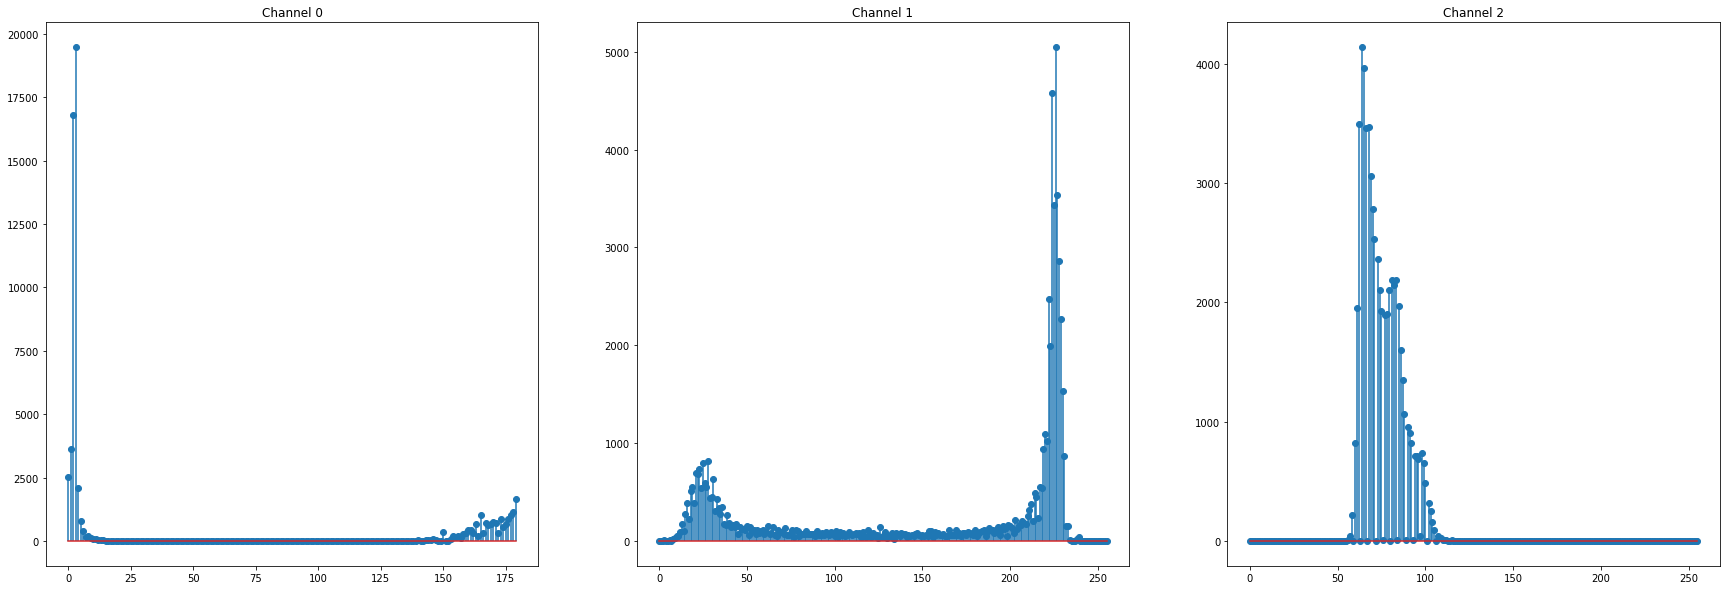

In [16]:
# HSV distribution
plot_channel_hist(central_region_crop)

It can be noticed that:
- the two peaks in channel 0 (Hue - color) identify the two colors: red and grey
- the two peaks in channel 1 (Saturation - amount of color) indentify two different sets of pixel: the peak on the right (the greater one) corresponds to the  set of high contrast dark red pixels, while the weakest one (because a smaller number of pixels of that kind has been taken into account) corresponds to the grey contours, and so it represents the decoration

In [17]:
# Color segmentation
red = color_segmentation(img, hsv, config.red_lower_bound, config.red_upper_bound)

cv2.imshow('red',red)
cv2.imwrite(f'{config.report_img_path}dark_red_cap.jpg',red)

cv2.waitKey(0)
cv2.destroyAllWindows()

## 3. Cap detection

In this section the red cap is detected through Circle Hough Transform.

Although OpenCV HoughCircles already implements a smoothing step, I have experimentally noticed that another smoothing step by a $5\times 5$ median filter improved performances.

Configuratoin parameters have been determined by experiments and qualitative assesments, because no ground truth was provided.

Circles detection is accomplished throug OpenCV HoughCircles function. Its argument are:
- image: 8-bit, single channel image;
- method: defines the method to detect circles in images. Currently, the only implemented method is cv2.HOUGH_GRADIENT, which corresponds to the Yuen et al. paper.
- dp: this parameter is the inverse ratio of the accumulator resolution to the image resolution (see Yuen et al. for more details). Essentially, the larger the dp gets, the smaller the accumulator array gets.
- minDist: Minimum distance between the center (x, y) coordinates of detected circles. If the minDist is too small, multiple circles in the same neighborhood as the original may be (falsely) detected. If the minDist is too large, then some circles may not be detected at all.
- param1: First method-specific parameter. In case of HOUGH_GRADIENT , it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller).
- param2: Accumulator threshold value for the cv2.HOUGH_GRADIENT method. The smaller the threshold is, the more circles will be detected (including false circles).
- minRadius: Minimum size of the radius (in pixels).
- maxRadius: Maximum size of the radius (in pixels).

In [19]:
# Smooth image before HT
cap_smooth = smooth(red, config.cap_filter)

In [20]:
## Red cap detection
cap = single_detect_circles(cap_smooth, config.cap_minDist, config.cap_param1, config.cap_param2, config.cap_minRadius, config.cap_maxRadius, print_result=False, show=True)

cap_a,cap_b,cap_r = cap
print(f'Cap center = ({cap_a},{cap_b})')
print(f'Cap radius = {cap_r}px')

Cap center = (374,308)
Cap radius = 210px


## 4. Decoration's color segmentation

As stated in section 2, color distribution analysis highlighted two different colors, one for the cap and the other for the decoration. 

In this section decoration color segmentation is employed, after masking the original image with the cap circumference found before.

In [21]:
# Let's focus only on the region contained in the detected cap circle
m = np.zeros(img.shape[:2], dtype=np.uint8)
m = cv2.circle(m, (cap_a,cap_b), cap_r, 255, -1)
masked = cv2.bitwise_and(img, img, mask=m)

cv2.imshow('masked', masked)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
# Decoration color segmentation
grey = color_segmentation(masked, hsv, config.grey_lower_bound, config.grey_upper_bound)

cv2.imshow('grey',grey)
cv2.imwrite(f'{config.report_img_path}grey_decoration.jpg',grey)

cv2.waitKey(0)
cv2.destroyAllWindows()

## 5. Decoration detection

As for cap detection, decoration is found by first applying a $3\times 3$ bilateral filter and then a Circle Hough Transform.

In [13]:
# Smooth image before HT
decoration_smooth = smooth(grey, filter=config.decoration_filter)

In [15]:
# Decoration circle detecion
maxRadius = cap_r

decoration = single_detect_circles(decoration_smooth, config.decoration_minDist, config.decoration_param1, config.decoration_param2, config.decoration_minRadius, maxRadius, print_result=False, save_img_as='grey_decoration_CHT.jpg')

decoration_a,decoration_b,decoration_r = decoration
print(f'Decoration center = ({decoration_a},{decoration_b})')
print(f'Decoration radius = {decoration_r}px')

Decoration center = (382,300)
Decoration radius = 188px


## 6. Compute off-set

At the end, the decoration off-set is computed as the Euclidean distance between cap's center and decoration's center.

In [112]:
_ = compute_distance(cap, decoration)

Distance between cap and decoration centers = 14.14px


In [18]:
cimg = draw_circles(img, [cap, decoration], show=True)